In [2]:
import time
import tensorflow as tf
# import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from textwrap import wrap
from tensorflow.keras import Input
from tensorflow.keras.layers import (
    LSTM,
    GRU,
    TextVectorization,
    StringLookup,
    Reshape,
    Dense,
    Embedding,
    Attention,
    Add,
    LayerNormalization
)

In [3]:
VOCAB_SIZE = 20000
ATTENTION_DIM = 512
BATCH_SIZE = 128
WORD_EMBEDDING_DIM = 128
FEATURE_EXTRACTOR = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False,weights='imagenet')
IMG_WIDTH = 299
IMG_HEIGHT = 299
IMG_CHANNELS = 3
FEATURES_SHAPE =(8,8,1536)



219055592/219055592 [==============================] - 15s 0us/step


In [3]:
GCS_DIR = "gs://asl-public/data/tensorflow_datasets/"
BUFFER_SIZE = 1000
def get_img_caption(example):
  caption = example['captions']['text'][0]
  start = tf.convert_to_tensor("<START>")
  end = tf.convert_to_tensor("<END>")
  caption = tf.strings.join([start,caption,end],separator=" ")
  img = tf.image.resize(example['image'],(IMG_HEIGHT,IMG_WIDTH))
  img = img/255
  return {"image_tensor":img ,"captions": caption}

train_ds = tfds.load("coco_captions", split="train", data_dir=GCS_DIR)
train_ds = train_ds.map(
    get_img_caption,num_parallel_calls = tf.data.AUTOTUNE
).shuffle(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size = tf.data.AUTOTUNE)

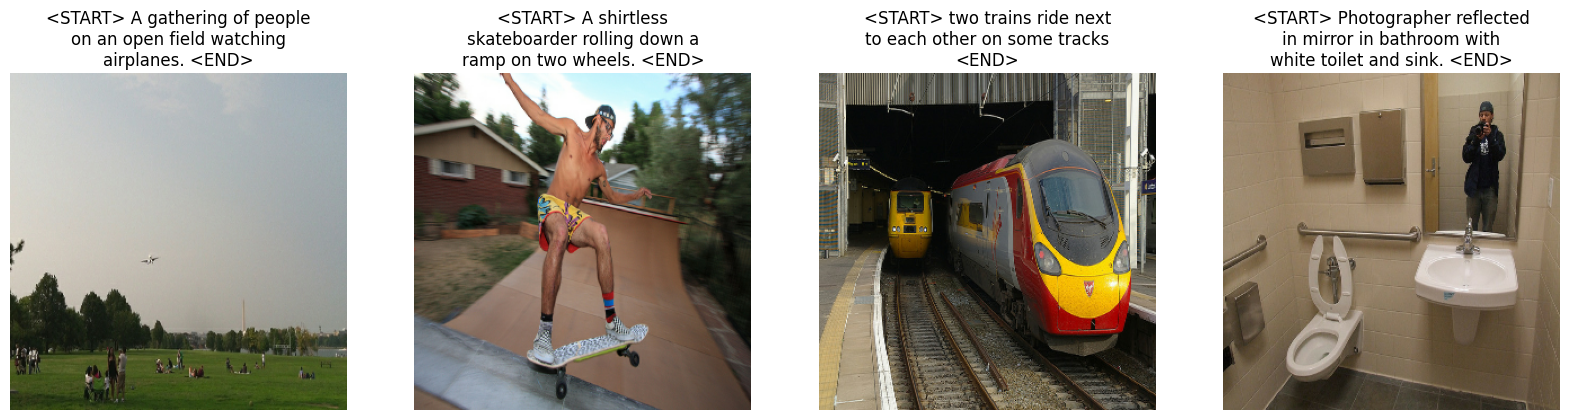

In [4]:
fig ,ax = plt.subplots(1,4,figsize=(20,5))
for idx, data in enumerate(train_ds.take(4)):
  ax[idx].imshow(data['image_tensor'].numpy())
  caption = "\n".join(wrap(data["captions"].numpy().decode("utf-8"),30))
  ax[idx].set_title(caption)
  ax[idx].axis("off")

In [4]:
MAX_CAPTION_LENGTH = 64

In [5]:
def standardize(inputs):
  input = tf.strings.lower(inputs)
  return tf.strings.regex_replace(
      input, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", ""
  )

tokenizer = TextVectorization(
    max_tokens = VOCAB_SIZE,
    standardize=standardize,
    output_sequence_length = MAX_CAPTION_LENGTH
)
tokenizer.adapt(train_ds.map(lambda x: x["captions"]))

In [6]:
tokenizer(["<START> This is the beginning of a sentence. <END>"])

<tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[   3,  165,   11,    7, 3053,    5,    2,    1,    4,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [7]:
word_to_index = StringLookup(
    mask_token="", vocabulary = tokenizer.get_vocabulary())
index_to_word = StringLookup(
    mask_token="", vocabulary = tokenizer.get_vocabulary() , invert=True
)

In [8]:
BATCH_SIZE = 16
def create_ds_fn(data):
  img = data["image_tensor"]
  caption = tokenizer(data["captions"])
  target = tf.roll(caption,-1,0)
  zeros = tf.zeros([1],dtype=tf.int64)
  target = tf.concat((target[:-1],zeros),axis=-1)
  return (img,caption),target

batch_ds = (train_ds.map(create_ds_fn)
.batch(BATCH_SIZE,drop_remainder=True)
.prefetch(buffer_size = tf.data.AUTOTUNE)
)

In [9]:
for (img,caption),label in batch_ds.take(2):
  print(img.shape)
  print(caption.shape)
  print(label.shape)

(16, 299, 299, 3)
(16, 64)
(16, 64)
(16, 299, 299, 3)
(16, 64)
(16, 64)


In [10]:
FEATURE_EXTRACTOR.trainable = False
img_input = Input(shape=(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)) # (batch_size , 299, 299, 3)
image_features = FEATURE_EXTRACTOR(img_input) # (batch_size , 299, 299, 3)
x = Reshape((FEATURES_SHAPE[0] * FEATURES_SHAPE[1],FEATURES_SHAPE[2]))(
    image_features
) # (batch_size, 64, 1536)
encoder_output = Dense(ATTENTION_DIM,activation="relu")(x) # (batch_size , 64, 512)

In [11]:
encoder = tf.keras.Model(inputs = img_input,outputs = encoder_output)

In [12]:
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_resnet_v2 (Funct  (None, None, None, 1536   54336736  
 ional)                      )                                   
                                                                 
 reshape_1 (Reshape)         (None, 64, 1536)          0         
                                                                 
 dense_1 (Dense)             (None, 64, 512)           786944    
                                                                 
Total params: 55123680 (210.28 MB)
Trainable params: 786944 (3.00 MB)
Non-trainable params: 54336736 (207.28 MB)
_________________________________________________________________


In [13]:
word_input = Input(shape=(MAX_CAPTION_LENGTH),name="words") # (batch_size, 64)
embedd_x = Embedding(VOCAB_SIZE,ATTENTION_DIM)(word_input) # (batch_size, 64, 512)
decoder_gru = GRU(ATTENTION_DIM,return_sequences=True,return_state=True)
gru_output,gru_state = decoder_gru(embedd_x) # (batch_size, 64, 512) , (batch_size, 512)
decoder_attention = Attention()
context_vector = decoder_attention([gru_output,encoder_output]) # (batch_size, 64, 512)
addition = Add()([gru_output,context_vector]) # (batch_size, 64, 512)
layer_norm = LayerNormalization(axis = -1)
layer_norm_out = layer_norm(addition) # (batch_size, 64, 512)
decoder_output_dense = Dense(VOCAB_SIZE)
decoder_output = decoder_output_dense(layer_norm_out) # (batch_size, 64, 20000)

In [14]:
decoder = tf.keras.Model(
    inputs = [word_input,encoder_output], outputs = decoder_output
)
decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 words (InputLayer)          [(None, 64)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 64, 512)              1024000   ['words[0][0]']               
                                                          0                                       
                                                                                                  
 gru (GRU)                   [(None, 64, 512),            1575936   ['embedding[1][0]']           
                              (None, 512)]                                                        
                                                                                            

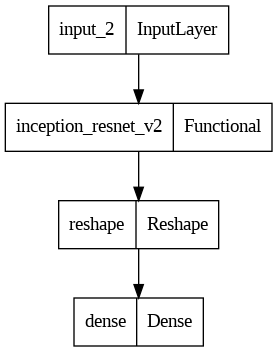

In [15]:
tf.keras.utils.plot_model(encoder)

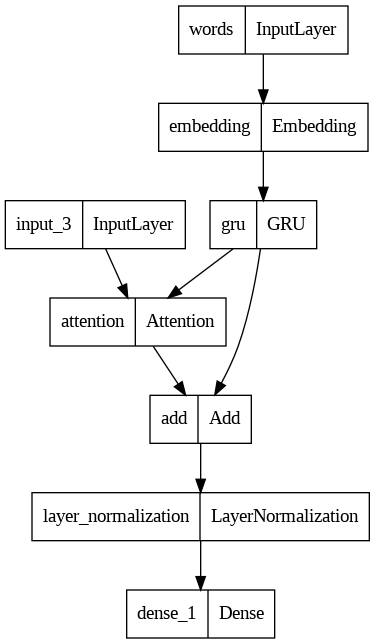

In [16]:
tf.keras.utils.plot_model(decoder)

# Training Model

In [17]:
train_model = tf.keras.Model(
    inputs=[img_input,word_input], outputs = decoder_output
)
train_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 words (InputLayer)          [(None, 64)]                 0         []                            
                                                                                                  
 inception_resnet_v2 (Funct  (None, None, None, 1536)     5433673   ['input_2[0][0]']             
 ional)                                                   6                                       
                                                                                                  
 embedding (Embedding)       (None, 64, 512)              1024000   ['words[0][0]']         

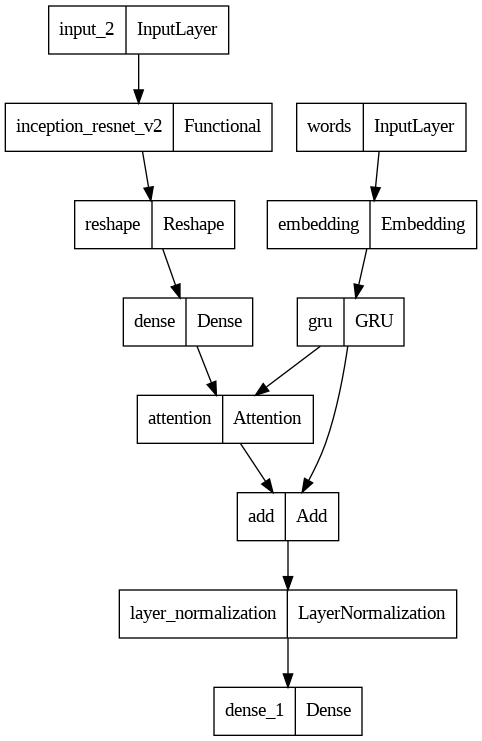

In [18]:
tf.keras.utils.plot_model(train_model)

In [19]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True,reduction="none")
def loss_func(real,pred):
  loss_ = loss_object(real,pred)
  mask = tf.logical_not(tf.math.equal(real,0))
  mask = tf.cast(mask,tf.int32)
  sentence_len = tf.reduce_sum(mask)
  loss = loss_[:sentence_len]
  return tf.reduce_mean(loss)

In [20]:
train_model.compile(optimizer="adam",loss=loss_func, metrics=["accuracy"])

In [21]:
%%time
history = train_model.fit(batch_ds, epochs=3,verbose='auto')

Epoch 1/3
5173/5173 [==============================] - 1172s 222ms/step - loss: 0.5478 - accuracy: 0.8996
Epoch 2/3
5173/5173 [==============================] - 1147s 221ms/step - loss: 0.4152 - accuracy: 0.9104
Epoch 3/3
5173/5173 [==============================] - 1149s 222ms/step - loss: 0.3640 - accuracy: 0.9159
CPU times: user 43min 23s, sys: 4min 21s, total: 47min 44s
Wall time: 58min 3s


In [22]:
train_model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Prediction Model

In [23]:
gru_state_input = Input(shape=(ATTENTION_DIM),name="gru_state_input")
# Reuse trained GRU
gru_output, gru_state = decoder_gru(embedd_x,initial_state=gru_state_input)

# Reuse other layers as well
context_vector = decoder_attention([gru_output,encoder_output])
addition_output = Add()([gru_output,context_vector])
layer_norm_out = layer_norm(addition)
decoder_output = decoder_output_dense(layer_norm_out)

decoder_pred_model = tf.keras.Model(
    inputs = [word_input,gru_state_input,encoder_output],
    outputs = [decoder_output,gru_state]
)

In [24]:
decoder_pred_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 words (InputLayer)          [(None, 64)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 64, 512)              1024000   ['words[0][0]']               
                                                          0                                       
                                                                                                  
 gru (GRU)                   [(None, 64, 512),            1575936   ['embedding[2][0]',           
                              (None, 512)]                           'gru_state_input[0][0]',     
                                                                     'embedding[2][0]']     

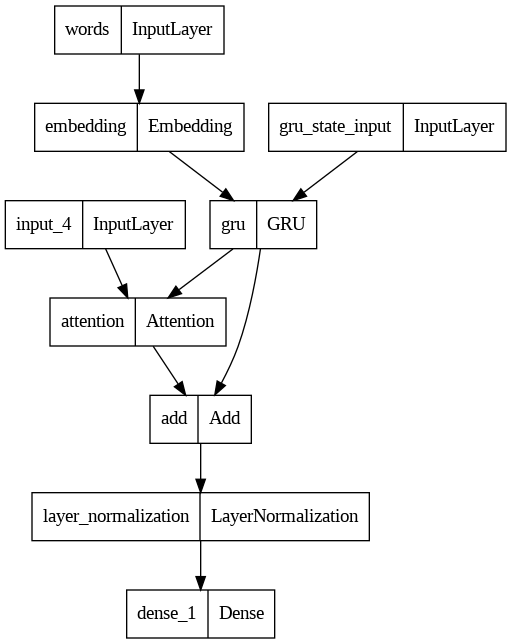

In [25]:
tf.keras.utils.plot_model(decoder_pred_model)

In [26]:
MINIMUM_SENTENCE_LENGTH = 5

def predict_caption(filename):
  gru_state = tf.zeros((1,ATTENTION_DIM))
  img = tf.image.decode_jpeg(tf.io.read_file(filename),channels = IMG_CHANNELS)
  img = tf.image.resize(img,(IMG_HEIGHT,IMG_WIDTH))
  img = img/255

  features = encoder(tf.expand_dims(img,axis=0))
  decoder_input = tf.expand_dims([word_to_index("<START>")],1)
  result = []
  for i in range(MAX_CAPTION_LENGTH):
    predictions , gru_state = decoder_pred_model(
        [decoder_input,gru_state,features]
    )
    top_probs, top_indxs = tf.math.top_k(
        input = predictions[0][0], k=10, sorted = False
    )
    chosen_id = tf.random.categorical([top_probs],1)[0].numpy()
    predicted_id = top_indxs.numpy()[chosen_id][0]
    result.append(tokenizer.get_vocabulary()[predicted_id])

    if predicted_id == '<END>':
      return img, result
    dec_input = tf.expand_dims([predicted_id],1)
  return img, result

is on a down is skateboarder is is a a a on and a and on a skateboard and a the a a and a down street a skateboard down a a a down a skateboard skateboard a a a is the a on a skateboard a a a and skateboarder a street skateboarder a skateboard skateboard a an a a down street.


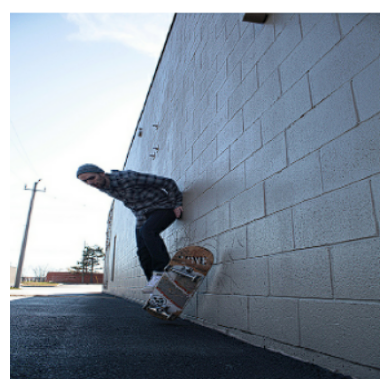

In [27]:
filename = 'Screenshot 2024-02-13 232829.png' # you can also try surf.jpeg

# for i in range(1):
image, caption = predict_caption(filename)
print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");